In [1]:
# Load data and define sharpe function to evaluate the models: 
#need volatility data and the data from the risk_adjusted_returns file:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Get volatility historical data:
url_volatility = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/volatility_data.csv'
volatility_df = pd.read_csv(url_volatility)
#make the date a datetime object:
volatility_df['Date'] = pd.to_datetime(volatility_df['Date'])

# first we need the historical data: 
url_nasdaq_price = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/QQQ.csv'
price_df = pd.read_csv(url_nasdaq_price)
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_df.head()
#this dataset includes the prices and the volume!
# we now need to calculate the returns:
price_df['r_ndq'] = (price_df['Adj Close'] - price_df['Adj Close'].shift(1)) / price_df['Adj Close'].shift(1)
price_df.dropna(inplace=True)
price_df.head()

rf_df = pd.read_csv('https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/IEF.csv')
rf_df['r_rf'] = (rf_df['Adj Close'] - rf_df['Adj Close'].shift(1)) / rf_df['Adj Close'].shift(1)
rf_df.dropna(inplace=True)
rf_df['Date'] = pd.to_datetime(rf_df['Date'])

portfolio_df = pd.merge(price_df[['Date', 'r_ndq']], 
                     rf_df[['Date', 'r_rf']], 
                     on='Date', 
                     how='inner')

portfolio_df = pd.merge(portfolio_df,  
                     volatility_df[['Date', 'Price']],
                     on='Date', 
                     how='inner')

portfolio_df.rename(columns={'Price' : 'Volatility'}, inplace = True)
portfolio_df.head()

r_rf_df = pd.read_csv('https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/risk_free_rate.csv')

#divide by 100 because it was already in % -> we dont want that here!
#then divide by 252 since its on a yearly basis but everything else is on a daily basis
#(252 ~ number of us trading days a year)
r_rf_df['rf_rate'] = r_rf_df['rf_rate']/(100*252)
r_rf_df['Date'] = pd.to_datetime(r_rf_df['Date'])
#r_rf_df.set_index('Date', inplace=True)
r_rf_df.head()

portfolio_df = pd.merge(portfolio_df, 
                        r_rf_df[['Date', 'rf_rate']], 
                        on='Date', 
                        how='inner')

sentiment_index_df = pd.read_excel('https://raw.githubusercontent.com/inga-maria01/master_thesis/main/index/sentiment_index_unweighted_v7.xlsx')
sentiment_index_df.rename(columns={'date':'Date'}, inplace=True)
sentiment_index_df['lag_sentiment'] = sentiment_index_df['sentiment_score'].shift(1)
sentiment_index_df.head()

portfolio_df_sent = pd.merge(portfolio_df, sentiment_index_df, on='Date', how='inner')
portfolio_df_sent.set_index('Date', inplace=True)
portfolio_df_sent['moving_average_10day'] = portfolio_df_sent['sentiment_score'].rolling(window = 10).mean()

#want to just look at the training period for threshold optimization
#and then just at the test period for calculating the sharpe
portfolio_df_sent_train = portfolio_df_sent[:'2018-06-30'].copy()
portfolio_df_sent_test = portfolio_df_sent['2018-07-01':].copy()

def overall_sharpe_sentiment_calc(sentiment):
    w_ndq = []
    w_rf = []
    for score in sentiment:
        if score > 21.3: #23: changing to see if it improves
            w_ndq.append(0.8)
            w_rf.append(0.2)
        elif score <= 21.3 and score > 20: # was 20:
            w_ndq.append(0.6)
            w_rf.append(0.4)
        elif score <= 20:
            w_ndq.append(0.2)
            w_rf.append(0.8)
    portfolio_df_sent_test['w_ndq'] = w_ndq
    portfolio_df_sent_test['w_rf'] = w_rf
    portfolio_df_sent_test['r_portfolio'] = portfolio_df_sent_test['w_ndq'] * portfolio_df_sent_test['r_ndq'] + portfolio_df_sent_test['w_rf'] * portfolio_df_sent_test['r_rf']
    portfolio_df_sent_test['excess returns'] = portfolio_df_sent_test['r_portfolio'] - portfolio_df_sent_test['rf_rate']
    portfolio_df_sent_test['trading day'] = (portfolio_df_sent_test['w_ndq'] != portfolio_df_sent_test['w_ndq'].shift(1)).astype(int)
    mean_return_portfolio = portfolio_df_sent_test['r_portfolio'].mean()
    std_excess = np.std(portfolio_df_sent_test['excess returns'])
    mean_risk_free_rate = portfolio_df_sent_test['rf_rate'].mean()
    sharpe_ratio = (mean_return_portfolio - mean_risk_free_rate)/std_excess
    return sharpe_ratio

--------------------------------
Sharpe functions:

In [2]:
portfolio_df_sent_rolling = portfolio_df_sent['moving_average_10day']['2017-10-01':]

In [3]:
# Define the window size and alpha for exponential decay
window_size = 60
alpha = 0.9

# Compute exponential weights
weights = np.array([alpha**(i) for i in range(window_size)])
weights = np.flip(weights)
# Normalize weights
weights /= weights.sum()

# Define the custom function to calculate quantiles with weights
def weighted_quantile(values, quantile=0.5):
    # Ensure the values are sorted
    sorter = np.argsort(values)
    values_sorted = values[sorter]
    weights_sorted = weights[sorter]

    # Compute the cumulative sum of weights
    cumsum = np.cumsum(weights_sorted)

    # Find where the cumulative sum equals or exceeds the quantile
    return np.interp(quantile, cumsum, values_sorted)

def overall_sharpe_sentiment_prec_exp(sentiment):
    w_ndq = []
    w_rf = []

    # Assuming 'sentiment' is a pandas Series
    upper = portfolio_df_sent_rolling.shift(1).rolling(60).apply(lambda x: weighted_quantile(x, quantile=0.75), raw=True)
    lower = portfolio_df_sent_rolling.shift(1).rolling(60).apply(lambda x: weighted_quantile(x, quantile=0.25), raw=True)
    test_sent = sentiment['2018-07-01':]
    for i in test_sent.index:
        score = sentiment[i]
        if score > upper[i]: #23: changing to see if it improves
            w_ndq.append(0.8)
            w_rf.append(0.2)
        elif score <= upper[i] and score > lower[i]: # was 20:
            w_ndq.append(0.6)
            w_rf.append(0.4)
        elif score <= lower[i]:
            w_ndq.append(0.2)
            w_rf.append(0.8)
    portfolio_df_sent_test['w_ndq'] = w_ndq
    portfolio_df_sent_test['w_rf'] = w_rf
    portfolio_df_sent_test['r_portfolio'] = portfolio_df_sent_test['w_ndq'] * portfolio_df_sent_test['r_ndq'] + portfolio_df_sent_test['w_rf'] * portfolio_df_sent_test['r_rf']
    portfolio_df_sent_test['excess returns'] = portfolio_df_sent_test['r_portfolio'] - portfolio_df_sent_test['rf_rate']
    portfolio_df_sent_test['trading day'] = (portfolio_df_sent_test['w_ndq'] != portfolio_df_sent_test['w_ndq'].shift(1)).astype(int)
    mean_return_portfolio = portfolio_df_sent_test['r_portfolio'].mean()
    std_excess = np.std(portfolio_df_sent_test['excess returns'])
    mean_risk_free_rate = portfolio_df_sent_test['rf_rate'].mean()
    sharpe_ratio = (mean_return_portfolio - mean_risk_free_rate)/std_excess
    return sharpe_ratio, upper, lower

In [4]:
def overall_sharpe_sentiment_precentiles(sentiment):
    w_ndq = []
    w_rf = []

    upper = portfolio_df_sent_rolling.shift(1).rolling(60, min_periods = 1).quantile(0.75)
    lower = portfolio_df_sent_rolling.shift(1).rolling(60, min_periods = 1).quantile(0.25)
    #test_sent = sentiment['2018-01-01':]
    for i in sentiment.index:
        score = sentiment[i]
        if score > upper[i]: #23: changing to see if it improves
            w_ndq.append(0.8)
            w_rf.append(0.2)
        elif score <= upper[i] and score > lower[i]: # was 20:
            w_ndq.append(0.6)
            w_rf.append(0.4)
        elif score <= lower[i]:
            w_ndq.append(0.2)
            w_rf.append(0.8)
    portfolio_df_sent_test['w_ndq'] = w_ndq
    portfolio_df_sent_test['w_rf'] = w_rf
    portfolio_df_sent_test['r_portfolio'] = portfolio_df_sent_test['w_ndq'] * portfolio_df_sent_test['r_ndq'] + portfolio_df_sent_test['w_rf'] * portfolio_df_sent_test['r_rf']
    portfolio_df_sent_test['excess returns'] = portfolio_df_sent_test['r_portfolio'] - portfolio_df_sent_test['rf_rate']
    portfolio_df_sent_test['trading day'] = (portfolio_df_sent_test['w_ndq'] != portfolio_df_sent_test['w_ndq'].shift(1)).astype(int)
    mean_return_portfolio = portfolio_df_sent_test['r_portfolio'].mean()
    std_excess = np.std(portfolio_df_sent_test['excess returns'])
    mean_risk_free_rate = portfolio_df_sent_test['rf_rate'].mean()
    sharpe_ratio = (mean_return_portfolio - mean_risk_free_rate)/std_excess
    return sharpe_ratio, upper, lower

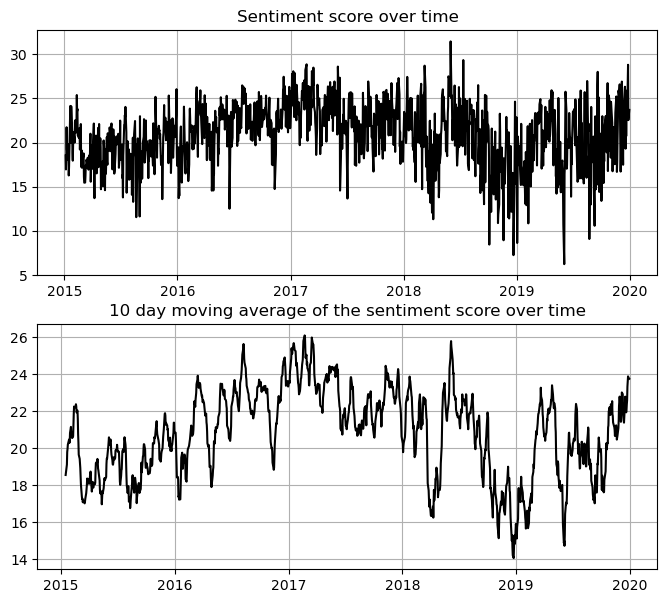

In [5]:
plt.figure(figsize=(8,7))
plt.subplot(2,1,1)
plt.title('Sentiment score over time')
plt.grid(True)
plt.plot(portfolio_df_sent['sentiment_score'], color = 'black')
plt.subplot(2,1,2)
plt.title('10 day moving average of the sentiment score over time')
plt.grid(True)
plt.plot(portfolio_df_sent['moving_average_10day'], color = 'black')

In [6]:
import warnings
from statsmodels.tsa.arima.model import ARIMA

# Ignore all warnings
warnings.filterwarnings("ignore")

# Determine optimal lag value with AIC and BIC for ARMA

# AIC
aic_values_arma = []

max_lag = 4

# Fit ARMA models with different lag orders
for p in range(0, max_lag + 1):
    for q in range(0, max_lag + 1):
        model_arma = ARIMA(sentiment_index_df['sentiment_score'], order=(p, 0, q))  # (p, d, q) for ARMA model
        results_arma = model_arma.fit()
        aic_values_arma.append((p, q, results_arma.aic))

# Find the lag orders with the lowest AIC
optimal_lag_aic_arma = min(aic_values_arma, key=lambda x: x[2])  # Minimum AIC tuple
print("Optimal lag orders based on AIC for ARMA model:", optimal_lag_aic_arma)

# BIC
bic_values_arma = []

# Fit ARMA models with different lag orders
for p in range(0, max_lag + 1):
    for q in range(0, max_lag + 1):
        model_arma = ARIMA(sentiment_index_df['sentiment_score'], order=(p, 0, q))
        results_arma = model_arma.fit()
        bic_values_arma.append((p, q, results_arma.bic))

# Find the lag orders with the lowest BIC
optimal_lag_bic_arma = min(bic_values_arma, key=lambda x: x[2])  # Minimum BIC tuple
print("Optimal lag orders based on BIC for ARMA model:", optimal_lag_bic_arma)

Optimal lag orders based on AIC for ARMA model: (2, 2, 8796.933099483249)
Optimal lag orders based on BIC for ARMA model: (2, 1, 8827.391925361075)


In [7]:
sentiment_index_df.set_index('Date', inplace=True)

In [8]:
sentiment_df_train = sentiment_index_df[:'2018-06-30'].copy()
sentiment_df_test = sentiment_index_df['2018-07-01':].copy()

y_train = sentiment_df_train['sentiment_score'].copy()
y_test = sentiment_df_test['sentiment_score'].copy()

from sklearn.metrics import mean_squared_error, r2_score

In [9]:
# Rolling window (window size is 80% of data)

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


# Initialize lists to store MSE values and forecasts
res_list = []
forecast_list = []
conf = []

#initial training and test sets:
train_data = y_train.copy() # ['sentiment_score'].copy()
test_data = y_test.copy() #sentiment_df_test['sentiment_score'].copy()

for i in test_data.index:
    #print(len(train_data))
    # model = AutoReg(train_data, lags=optimal_lag_bic) # optimal lag = 10
    model = ARIMA(train_data, order=(2, 0, 1))
    model_fit = model.fit()

    #forecast = model_fit.predict(start=len(train_data), end=len(train_data))
    # forecast = model_fit.forecast(steps=1)
    get_forecast = model_fit.get_forecast(steps=1)

    forecast = get_forecast.predicted_mean
    forecast_conf = get_forecast.conf_int(alpha=0.05)

    #print(len(forecast))

    #print(forecast)
    forecast_list.append(forecast)
    conf.append(forecast_conf)

    #print(test_data[i])

    res = test_data[i] - forecast
    res_list.append(res)

    # Expand estimation window
    test_to_train = pd.Series([test_data[i]], index=[i])
    #print(test_to_train)
    train_data = pd.concat([train_data, test_to_train])
    train_data = train_data.iloc[1:]
    #print(len(train_data))


    #print(train_data[-5:])

# Calculate the overall average MSE
mse = np.mean(np.square(res))
print("Overall average MSE:", mse)

Overall average MSE: 0.8320983915083235


In [10]:
#calculate RMSE and R2:
rmse = np.sqrt(mean_squared_error(test_data, forecast_list))
r2 = r2_score(test_data, forecast_list)
print("RMSE:", rmse, "R2:", r2)

RMSE: 3.338302389203929 R2: 0.27620215482801636


In [11]:
values = [s.iloc[0] for s in forecast_list]  # `s.iloc[0]` accesses the first value in each Series

# Create a new Series from the list of values
forecast_series = pd.Series(values)
forecast_series.index = test_data.index

sharpe, upper, lower = overall_sharpe_sentiment_prec_exp(forecast_series[~forecast_series.index.isin(forecast_series.index.difference(portfolio_df_sent_test.index))])

In [12]:
sharpe

0.10853700998783204

In [13]:
overall_sharpe_sentiment_prec_exp(portfolio_df_sent_test['sentiment_score'])[0]

0.3644907324667983

In [14]:
portfolio_df_sent_test['trading day'].sum()

188

In [15]:
len(portfolio_df_sent_test)

373

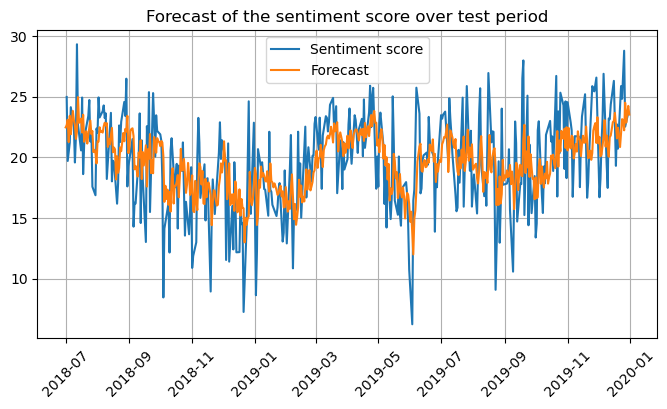

In [16]:
plt.figure(figsize=(8,4))
plt.plot(portfolio_df_sent_test['sentiment_score'], label='Sentiment score')
plt.plot(forecast_series, label = 'Forecast')
plt.grid(True)
plt.xticks(rotation=45)
plt.title('Forecast of the sentiment score over test period')
plt.legend()
plt.show()

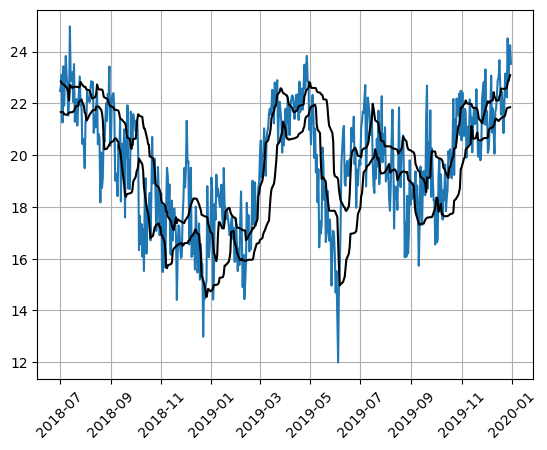

In [17]:
plt.plot(forecast_series)
plt.plot(upper['2018-07-01':], color = 'black')
plt.plot(lower['2018-07-01':], color = 'black')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [18]:
portfolio_df_sent_test['trading day'].sum()

188

In [19]:
len(portfolio_df_sent_test)

373

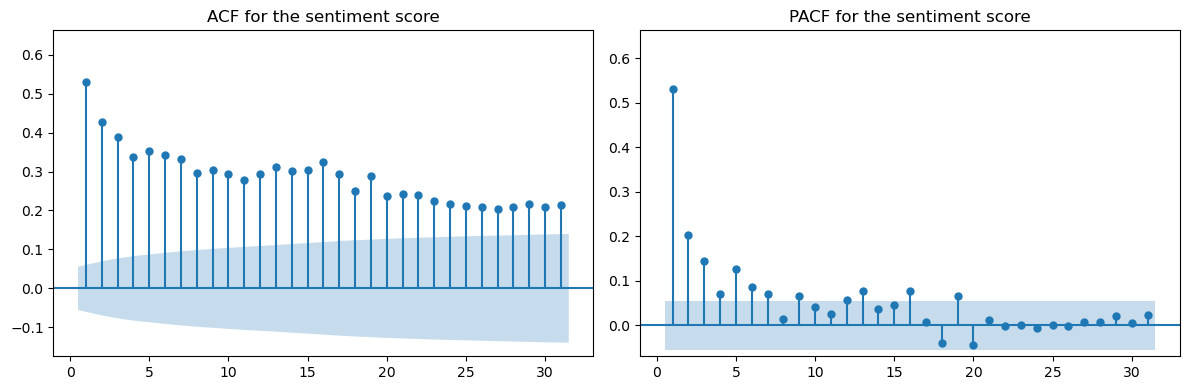

In [20]:
#Plot acf and pacf:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# ACF plot
ax1 = plt.subplot(1, 2, 1)
plot_acf(portfolio_df_sent['sentiment_score'].dropna(), zero=False, auto_ylims=True, ax=ax1, title='ACF for the sentiment score')

# PACF plot
ax2 = plt.subplot(1, 2, 2)
plot_pacf(portfolio_df_sent['sentiment_score'].dropna(), zero=False, auto_ylims=True, ax=ax2, title='PACF for the sentiment score')

plt.tight_layout()
plt.show()


--------------------------------------------------
### Modeling with 10 day moving average

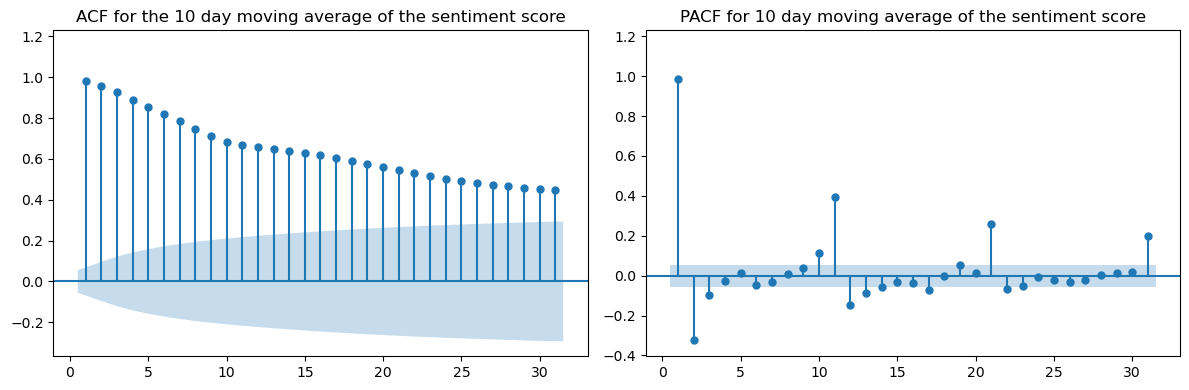

In [21]:
#Plot acf and pacf:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# ACF plot
ax1 = plt.subplot(1, 2, 1)
plot_acf(portfolio_df_sent['moving_average_10day'].dropna(), zero=False, auto_ylims=True, ax=ax1, title='ACF for the 10 day moving average of the sentiment score')

# PACF plot
ax2 = plt.subplot(1, 2, 2)
plot_pacf(portfolio_df_sent['moving_average_10day'].dropna(), zero=False, auto_ylims=True, ax=ax2, title='PACF for 10 day moving average of the sentiment score')

plt.tight_layout()
plt.show()


In [24]:
import warnings
from statsmodels.tsa.arima.model import ARIMA

# Ignore all warnings
warnings.filterwarnings("ignore")

# Determine optimal lag value with AIC and BIC for ARMA

# AIC
aic_values_arma = []

max_lag = 7

# Fit ARMA models with different lag orders
for p in range(0, max_lag + 1):
    for q in range(0, max_lag + 1):
        model_arma = ARIMA(portfolio_df_sent['moving_average_10day'].dropna(), order=(p, 0, q))  # (p, d, q) for ARMA model
        results_arma = model_arma.fit()
        aic_values_arma.append((p, q, results_arma.aic))

# Find the lag orders with the lowest AIC
optimal_lag_aic_arma = min(aic_values_arma, key=lambda x: x[2])  # Minimum AIC tuple
print("Optimal lag orders based on AIC for ARMA model:", optimal_lag_aic_arma)

# BIC
bic_values_arma = []

# Fit ARMA models with different lag orders
for p in range(0, max_lag + 1):
    for q in range(0, max_lag + 1):
        model_arma = ARIMA(portfolio_df_sent['moving_average_10day'].dropna(), order=(p, 0, q))
        results_arma = model_arma.fit()
        bic_values_arma.append((p, q, results_arma.bic))

# Find the lag orders with the lowest BIC
optimal_lag_bic_arma = min(bic_values_arma, key=lambda x: x[2])  # Minimum BIC tuple
print("Optimal lag orders based on BIC for ARMA model:", optimal_lag_bic_arma)

Optimal lag orders based on AIC for ARMA model: (7, 7, 807.9432717726895)
Optimal lag orders based on BIC for ARMA model: (5, 7, 884.5260792307288)


In [36]:

# Rolling window (window size is 80% of data)

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


# Initialize lists to store MSE values and forecasts
res_list = []
forecast_list = []
conf = []

#initial training and test sets:
#train_data = y_train.copy() # ['sentiment_score'].copy()
#test_data = y_test.copy() #sentiment_df_test['sentiment_score'].copy()
train_data = portfolio_df_sent[:'2018-06-30']['moving_average_10day'].dropna().copy()
test_data = portfolio_df_sent['2018-07-01':]['moving_average_10day'].copy()

for i in test_data.index:
    #print(len(train_data))
    # model = AutoReg(train_data, lags=optimal_lag_bic) # optimal lag = 10
    model = ARIMA(train_data, order=(10, 0, 10))
    model_fit = model.fit()

    #forecast = model_fit.predict(start=len(train_data), end=len(train_data))
    # forecast = model_fit.forecast(steps=1)
    get_forecast = model_fit.get_forecast(steps=1)

    forecast = get_forecast.predicted_mean
    forecast_conf = get_forecast.conf_int(alpha=0.05)

    #print(len(forecast))

    #print(forecast)
    forecast_list.append(forecast)
    conf.append(forecast_conf)

    #print(test_data[i])

    res = test_data[i] - forecast
    res_list.append(res)

    # Expand estimation window
    test_to_train = pd.Series([test_data[i]], index=[i])
    #print(test_to_train)
    train_data = pd.concat([train_data, test_to_train])
    train_data = train_data.iloc[1:]
    #print(len(train_data))


    #print(train_data[-5:])

# Calculate the overall average MSE
mse = np.mean(np.square(res))
print("Overall average MSE:", mse)

Overall average MSE: 0.005671318637346173


In [37]:
#calculate RMSE and R2:
rmse = np.sqrt(mean_squared_error(test_data, forecast_list))
r2 = r2_score(test_data, forecast_list)
print("RMSE:", rmse, "R2:", r2)

RMSE: 0.362180205363574 R2: 0.9743586098783227


In [38]:
#calculate RMSE and R2:
rmse = np.sqrt(mean_squared_error(test_data[0:300], forecast_list[0:300]))
r2 = r2_score(test_data[0:300], forecast_list[0:300])
print("RMSE:", rmse, "R2:", r2)

RMSE: 0.3589864395605717 R2: 0.9751238588192461


In [39]:
test_data[0:300]

Date
2018-07-02    21.717267
2018-07-03    21.349031
2018-07-05    21.070696
2018-07-06    21.597556
2018-07-09    22.109307
                ...    
2019-09-06    17.194727
2019-09-09    17.344651
2019-09-10    17.022181
2019-09-11    18.022639
2019-09-12    18.533170
Name: moving_average_10day, Length: 300, dtype: float64

In [40]:
# Extract numeric values from each Series in the list
values = [s.iloc[0] for s in forecast_list]  # `s.iloc[0]` accesses the first value in each Series

# Create a new Series from the list of values
forecast_series = pd.Series(values)
forecast_series.index = test_data.index

overall_sharpe_sentiment_prec_exp(forecast_series[~forecast_series.index.isin(forecast_series.index.difference(portfolio_df_sent_test.index))])[0]

0.05726218498837403

In [41]:
overall_sharpe_sentiment_prec_exp(portfolio_df_sent_test['moving_average_10day'])[0]

0.15136494405878678

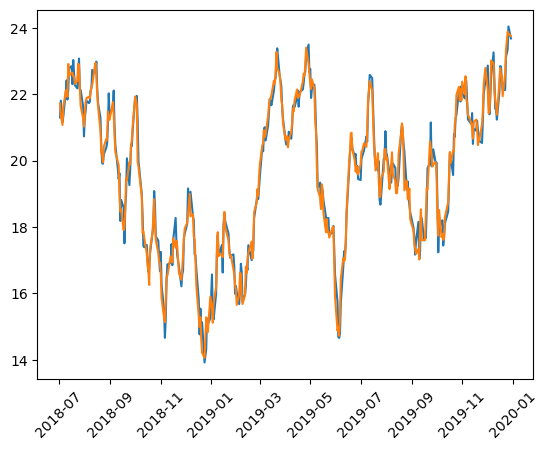

In [42]:
plt.plot(test_data.index, forecast_list)
plt.plot(test_data)
plt.xticks(rotation = 45)
#plt.ylim((13,25))
plt.show()

-----------------------------------------------

In [43]:
# try random forest, gradient boosting and xgboost:
# for that we need the lags of the moving average:

moving_average_df = portfolio_df_sent.copy().dropna()
moving_average_df['moving_average_10day_lag'] = moving_average_df['moving_average_10day'].shift(1)
moving_average_df['volatility_lag'] = moving_average_df['Volatility'].shift(1)
moving_average_df['r_ndq_lag'] = moving_average_df['r_ndq'].shift(1)
moving_average_df['slope_lag'] = moving_average_df['sentiment_slope'].shift(1)
moving_average_df = moving_average_df.dropna()

X_train_ma = moving_average_df[['moving_average_10day_lag', 'volatility_lag', 'r_ndq_lag', 'slope_lag' ]][:'2018-06-30']
X_test_ma = moving_average_df[['moving_average_10day_lag', 'volatility_lag', 'r_ndq_lag', 'slope_lag']]['2018-07-01':]
y_train_ma = moving_average_df['moving_average_10day'][:'2018-06-30']
y_test_ma = moving_average_df['moving_average_10day']['2018-07-01':]

In [44]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
# new y_train : train_residuals, new y_test : test_residuals

# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
    #"XGBoost": xgb.XGBRegressor(random_state = 42)
}

# Hyperparameters for tuning
parameters = {
    "Random Forest": {'n_estimators': range(25,40), 'max_depth': range(1,5)}, #number of trees in the forest and max depth
    "Gradient Boosting": {'n_estimators': range(20,30), 'learning_rate': np.linspace(0.2,0.5,7), 'max_depth': [1,3,4]}
    #"XGBoost": {'n_estimators': range(5,15), 'learning_rate': }
}

# Storing model performance
model_performance = {}
model_predictions = {}

# Tuning hyperparameters and evaluating each model
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]
    print(params)
    
    # Using GridSearchCV for hyperparameter tuning
    param_search = GridSearchCV(estimator=model, param_grid=params, cv=TimeSeriesSplit(), scoring='neg_mean_squared_error')
    param_search.fit(X_train_ma, y_train_ma)

    # Best model
    best_model = param_search.best_estimator_
    
    #Print the best model:
    print(best_model)
    
    # Predict on test set
    y_pred = best_model.predict(X_test_ma)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test_ma, y_pred))
    r2 = r2_score(y_test_ma, y_pred)

    # Store results
    model_performance[model_name] = {'RMSE': rmse, 
                                     'R2': r2,
                                     'Best Params': param_search.best_params_}

    # Store predictions to use for visualization:
    model_predictions[model_name] = {'y_pred' : y_pred}
    
# Output model performance

print(model_performance)

Model:   Random Forest
{'n_estimators': range(25, 40), 'max_depth': range(1, 5)}
RandomForestRegressor(max_depth=4, n_estimators=37, random_state=42)
Model:   Gradient Boosting
{'n_estimators': range(20, 30), 'learning_rate': array([0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ]), 'max_depth': [1, 3, 4]}
GradientBoostingRegressor(learning_rate=0.4, n_estimators=20, random_state=42)
{'Random Forest': {'RMSE': 0.6746991672544083, 'R2': 0.9110158834029989, 'Best Params': {'max_depth': 4, 'n_estimators': 37}}, 'Gradient Boosting': {'RMSE': 0.6527973046255352, 'R2': 0.9166992617878132, 'Best Params': {'learning_rate': 0.4, 'max_depth': 3, 'n_estimators': 20}}}


In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

# Define the parameter grid
rf_param_grid = {
    'n_estimators': [150, 200, 225, 250],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [5, 6, 7]
}

# Setup the grid search
rf_grid_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=TimeSeriesSplit(), scoring='neg_mean_squared_error')
rf_grid_search.fit(X_train_ma, y_train_ma)

# Best Random Forest model
rf_best_model = rf_grid_search.best_estimator_

pred = rf_best_model.predict(X_test_ma)
print(r2_score(y_test_ma, pred))

pred = pd.Series(pred)
pred.index = y_test_ma.index
final_prediction = pred[~pred.index.isin(pred.index.difference(portfolio_df_sent.index))]

0.9173479013686319


In [46]:
overall_sharpe_sentiment_prec_exp(final_prediction)[0]

0.0709340005160287

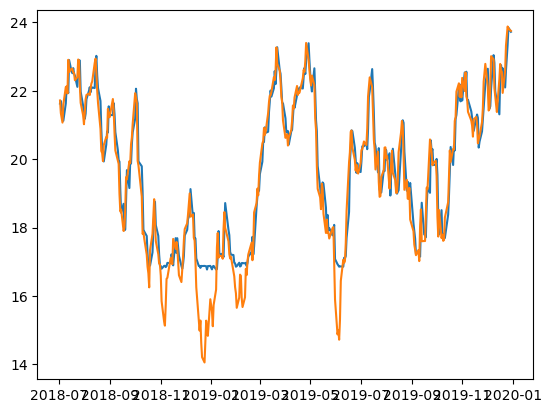

In [48]:
plt.plot(final_prediction)
plt.plot(portfolio_df_sent_test['moving_average_10day'])

In [49]:
# Define the parameter grid
gb_param_grid = {
    'n_estimators': [25, 75, 175, 200],
    'max_depth': [1, 3, 5],
    'min_samples_leaf': [1, 5, 6],
    'learning_rate': np.linspace(0.01, 0.15,15)
}

# Setup the grid search
gb_grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_param_grid, cv=TimeSeriesSplit(), scoring='neg_mean_squared_error')
gb_grid_search.fit(X_train_ma, y_train_ma)

# Best model
gb_best_model = gb_grid_search.best_estimator_
print("Best parameters:", gb_grid_search.best_params_)
pred = gb_best_model.predict(X_test_ma)
print(r2_score(y_test_ma, pred))

pred = pd.Series(pred)
pred.index = y_test_ma.index
final_prediction_gb = pred[~pred.index.isin(pred.index.difference(portfolio_df_sent.index))]

Best parameters: {'learning_rate': 0.08999999999999998, 'max_depth': 1, 'min_samples_leaf': 1, 'n_estimators': 200}
0.9160452827926404


In [50]:
overall_sharpe_sentiment_prec_exp(final_prediction_gb)[0]

0.08239697028446596

In [51]:
portfolio_df_sent

,r_ndq,r_rf,Volatility,rf_rate,sentiment_score,sentiment_slope,lag_sentiment,moving_average_10day
Date,,,,,,,,
2015-01-05,-0.014669,0.006101,18.00,1.190476e-06,18.532825,-1.688521,16.568480,NaN
2015-01-06,-0.013408,0.006718,19.05,1.190476e-06,16.950898,-0.425215,18.532825,NaN
2015-01-07,0.012891,-0.000186,17.20,1.190476e-06,18.343075,-1.852799,16.950898,NaN
2015-01-08,0.019140,-0.004079,16.61,1.190476e-06,21.728897,0.104260,18.343075,NaN
2015-01-09,-0.006583,0.004933,16.60,7.936508e-07,19.228589,-2.596250,21.728897,NaN
...,...,...,...,...,...,...,...,...
2019-12-23,0.002641,-0.000906,12.34,6.309524e-05,25.885680,-0.659049,22.631555,22.584993
2019-12-24,0.000519,0.001724,12.36,6.269841e-05,24.838901,-2.178170,25.885680,23.320627
2019-12-26,0.008824,0.001450,12.58,6.269841e-05,28.803194,1.745469,21.761798,23.880173


In [52]:
# Define the window size and alpha for exponential decay
window_size = 60
alpha = 0.9

# Compute exponential weights
weights = np.array([alpha**(i) for i in range(window_size)])
weights = np.flip(weights)
# Normalize weights
weights /= weights.sum()

# Define the custom function to calculate quantiles with weights
def weighted_quantile(values, quantile=0.5):
    # Ensure the values are sorted
    sorter = np.argsort(values)
    values_sorted = values[sorter]
    weights_sorted = weights[sorter]

    # Compute the cumulative sum of weights
    cumsum = np.cumsum(weights_sorted)

    # Find where the cumulative sum equals or exceeds the quantile
    return np.interp(quantile, cumsum, values_sorted)


labels = [np.nan]  # Initialize with NaN for the alignment
upper = portfolio_df_sent['moving_average_10day'].shift(1).rolling(60).apply(lambda x: weighted_quantile(x, quantile=0.75), raw=True)
lower = portfolio_df_sent['moving_average_10day'].shift(1).rolling(60).apply(lambda x: weighted_quantile(x, quantile=0.25), raw=True)
 
for i in portfolio_df_sent.index:
    if np.isnan(upper[i]) or np.isnan(lower[i]):
        labels.append(np.nan)  # Append NaN if either bound is NaN
    else:
        score = portfolio_df_sent['moving_average_10day'][i]
        if score > upper[i]:
            labels.append('risk-on')
        elif score <= upper[i] and score > lower[i]:
            labels.append('neutral')
        else:  # score <= lower[i]
            labels.append('risk-off')

# Assign labels to the DataFrame, adjusting for the initial NaN
portfolio_df_sent['label'] = labels[1:]  # Skip the first element to align with DataFrame indices


In [53]:
# import numpy as np

# # Add column that includes the labels for the classification:
# labels = [np.nan]  # Initialize with NaN for the alignment
# upper = portfolio_df_sent['moving_average_10day'].shift(1).rolling(60).quantile(0.75)
# lower = portfolio_df_sent['moving_average_10day'].shift(1).rolling(60).quantile(0.25)

# for i in portfolio_df_sent.index:
#     if np.isnan(upper[i]) or np.isnan(lower[i]):
#         labels.append(np.nan)  # Append NaN if either bound is NaN
#     else:
#         score = portfolio_df_sent['moving_average_10day'][i]
#         if score > upper[i]:
#             labels.append('risk-on')
#         elif score <= upper[i] and score > lower[i]:
#             labels.append('neutral')
#         else:  # score <= lower[i]
#             labels.append('risk-off')

# # Assign labels to the DataFrame, adjusting for the initial NaN
# portfolio_df_sent['label'] = labels[1:]  # Skip the first element to align with DataFrame indices


In [54]:
portfolio_df_sent['trading day'] = (portfolio_df_sent['label'] != portfolio_df_sent['label'].shift(1)).astype(int)

In [55]:
portfolio_df_sent['trading day'].sum()

363

In [56]:
363/len(portfolio_df_sent.dropna())

0.3081494057724958

increased to trading ca 1.5 times a week instead of 1 time a week when i changed to exponential decay thingy... 

In [57]:
portfolio_df_sent = portfolio_df_sent.dropna()

-----------------------------------
Try classification model:

In [58]:
portfolio_df_sent

,r_ndq,r_rf,Volatility,rf_rate,sentiment_score,sentiment_slope,lag_sentiment,moving_average_10day,label,trading day
Date,,,,,,,,,,
2015-04-15,0.006252,0.000552,12.51,7.936508e-07,16.505042,-1.703200,17.255311,17.873287,neutral,1
2015-04-16,-0.001391,0.000736,13.52,7.936508e-07,19.332187,-1.028328,16.505042,18.103298,neutral,0
2015-04-17,-0.015600,0.002023,14.73,3.968254e-07,18.399786,-1.458805,19.332187,18.094128,neutral,0
2015-04-20,0.014998,-0.001835,13.01,1.190476e-06,21.663542,1.820815,13.327287,18.045542,neutral,0
2015-04-21,0.004275,-0.002114,12.86,1.190476e-06,17.207107,1.574835,21.663542,18.150545,risk-on,1
...,...,...,...,...,...,...,...,...,...,...
2019-12-23,0.002641,-0.000906,12.34,6.309524e-05,25.885680,-0.659049,22.631555,22.584993,risk-on,1
2019-12-24,0.000519,0.001724,12.36,6.269841e-05,24.838901,-2.178170,25.885680,23.320627,risk-on,0
2019-12-26,0.008824,0.001450,12.58,6.269841e-05,28.803194,1.745469,21.761798,23.880173,risk-on,0


In [59]:
# try random forest, gradient boosting and xgboost:
# for that we need the lags of the moving average:

moving_average_df = portfolio_df_sent.copy().dropna()
moving_average_df['moving_average_10day_lag'] = moving_average_df['moving_average_10day'].shift(1)
moving_average_df['volatility_lag'] = moving_average_df['Volatility'].shift(1)
moving_average_df['r_ndq_lag'] = moving_average_df['r_ndq'].shift(1)
moving_average_df['slope_lag'] = moving_average_df['sentiment_slope'].shift(1)
moving_average_df = moving_average_df.dropna()

X_train_label = moving_average_df[['moving_average_10day_lag', 'volatility_lag', 'r_ndq_lag', 'slope_lag', 'moving_average_10day' ]][:'2018-06-30']
X_test_label = moving_average_df[['moving_average_10day_lag', 'volatility_lag', 'r_ndq_lag', 'slope_lag']]['2018-07-01':]
X_test_label['moving_average_10day'] = final_prediction
y_train_label = moving_average_df['label'][:'2018-06-30']
y_test_label = moving_average_df['label']['2018-07-01':]

In [60]:
def prepare_data(portfolio_df_sent):
    moving_average_df = portfolio_df_sent.copy().dropna()
    moving_average_df['moving_average_10day_lag'] = moving_average_df['moving_average_10day'].shift(1)
    moving_average_df['volatility_lag'] = moving_average_df['Volatility'].shift(1)
    moving_average_df['r_ndq_lag'] = moving_average_df['r_ndq'].shift(1)
    moving_average_df['slope_lag'] = moving_average_df['sentiment_slope'].shift(1)
    return moving_average_df.dropna()

In [61]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingClassifier
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [62]:
# Preparing data with historical actual values for features
data = prepare_data(portfolio_df_sent)
data['forecast_ma_10day'] = data['moving_average_10day']  # Placeholder for the ARIMA forecasts

# Define start and end dates for training and testing
train_start, train_end = pd.to_datetime('2015-01-01'), pd.to_datetime('2018-06-30')
test_start, test_end = pd.to_datetime('2018-07-01'), pd.to_datetime('2019-12-31')

# Start rolling window from the end of the initial training set
current = train_end

while current <= test_end:
    # Train ARIMA on all available actual data up to the current point
    train_data = data[:current]
    test_data = data[current:current + pd.DateOffset(days=1)]  # Daily increment

    # Fit ARIMA model to forecast the next day's moving average
    arima_model = ARIMA(train_data['moving_average_10day'], order=(3, 0, 4))
    arima_result = arima_model.fit()
    forecast = arima_result.forecast(steps=1).values[0]

    # Store the forecast in the test set as a feature for the prediction day
    data.loc[test_data.index, 'forecast_ma_10day'] = forecast

    # Prepare features for classification model
    features = ['moving_average_10day_lag', 'volatility_lag', 'r_ndq_lag', 'slope_lag', 'forecast_ma_10day']
    #if len(test_data) > 0:
        # Update features for the prediction day: replace actual moving average lag with the forecast
    #    train_data.loc[current, 'moving_average_10day_lag'] = forecast

    # Fit classification model on updated training data
    classifier = GradientBoostingClassifier(random_state=42)
    classifier.fit(train_data[features], train_data['label'])

    # Predict the next point and evaluate
    if len(test_data) > 0:
        predictions = classifier.predict(test_data[features])
        print(f"Accuracy for {current.date()}: {accuracy_score(test_data['label'], predictions)}")

    # Move the window one day ahead
    current += pd.DateOffset(days=1)


Accuracy for 2018-07-01: 0.0
Accuracy for 2018-07-02: 0.5
Accuracy for 2018-07-03: 1.0
Accuracy for 2018-07-04: 0.0
Accuracy for 2018-07-05: 0.5
Accuracy for 2018-07-06: 0.0
Accuracy for 2018-07-08: 0.0
Accuracy for 2018-07-09: 1.0
Accuracy for 2018-07-10: 0.5
Accuracy for 2018-07-11: 0.0
Accuracy for 2018-07-12: 0.5
Accuracy for 2018-07-13: 1.0
Accuracy for 2018-07-15: 1.0
Accuracy for 2018-07-16: 0.5
Accuracy for 2018-07-17: 0.5
Accuracy for 2018-07-18: 0.5
Accuracy for 2018-07-19: 0.5
Accuracy for 2018-07-20: 1.0
Accuracy for 2018-07-22: 1.0
Accuracy for 2018-07-23: 0.5
Accuracy for 2018-07-24: 1.0
Accuracy for 2018-07-25: 0.5
Accuracy for 2018-07-26: 0.5
Accuracy for 2018-07-27: 1.0
Accuracy for 2018-07-29: 0.0
Accuracy for 2018-07-30: 1.0
Accuracy for 2018-07-31: 1.0
Accuracy for 2018-08-01: 1.0
Accuracy for 2018-08-02: 0.5
Accuracy for 2018-08-03: 1.0
Accuracy for 2018-08-05: 0.0
Accuracy for 2018-08-06: 1.0
Accuracy for 2018-08-07: 1.0
Accuracy for 2018-08-08: 0.5
Accuracy for 2

Model:   Random Forest


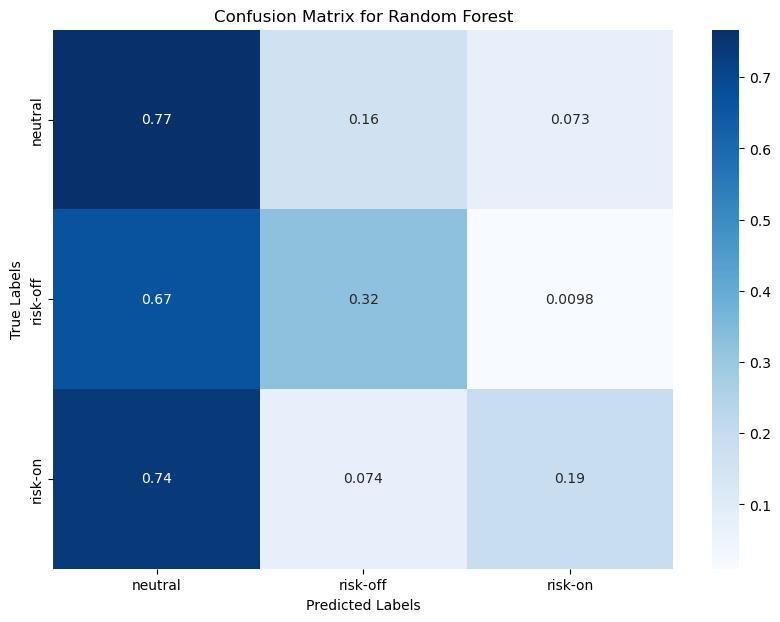

              precision    recall  f1-score   support

     neutral       0.42      0.77      0.55       150
    risk-off       0.50      0.32      0.39       102
     risk-on       0.66      0.19      0.29       121

    accuracy                           0.46       373
   macro avg       0.53      0.43      0.41       373
weighted avg       0.52      0.46      0.42       373

Model:   Gradient Boosting


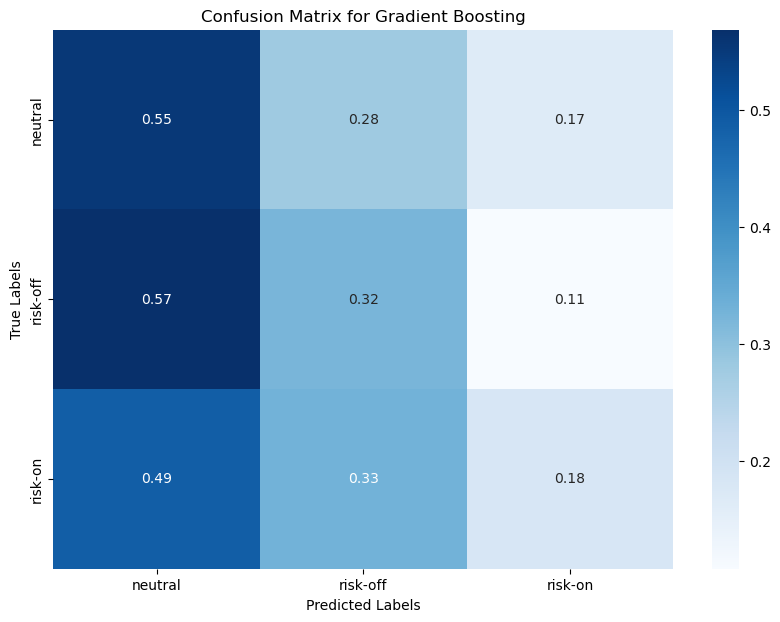

              precision    recall  f1-score   support

     neutral       0.41      0.55      0.47       150
    risk-off       0.29      0.32      0.30       102
     risk-on       0.38      0.18      0.25       121

    accuracy                           0.37       373
   macro avg       0.36      0.35      0.34       373
weighted avg       0.37      0.37      0.35       373

{'Random Forest': {'Accuracy': 0.4584450402144772, 'Precision': 0.5199286953387253, 'Recall': 0.4584450402144772, 'Best Params': {'max_depth': 2, 'n_estimators': 10}}, 'Gradient Boosting': {'Accuracy': 0.3699731903485255, 'Precision': 0.368407820218577, 'Recall': 0.3699731903485255, 'Best Params': {'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 25}}}


In [63]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
import seaborn as sns  

# Models to be used
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Hyperparameters for tuning
parameters = {
    "Random Forest": {'n_estimators': [10, 15, 20, 25, 30, 35, 40], 'max_depth': range(1, 5)},
    "Gradient Boosting": {'n_estimators': [10, 15, 20, 25, 30, 35, 40], 'learning_rate': np.linspace(0.25, 1.5, 6), 'max_depth': [1, 3, 4, 5]}
}

# Storing model performance
model_performance = {}

# Tuning hyperparameters and evaluating each model
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]
    
    # Using GridSearchCV for hyperparameter tuning
    param_search = GridSearchCV(estimator=model, param_grid=params, cv=TimeSeriesSplit(), scoring='accuracy')
    param_search.fit(X_train_label, y_train_label)  # Ensure y_train is now categorical

    # Best model
    best_model = param_search.best_estimator_
    
    # Predict on test set
    y_pred = best_model.predict(X_test_label)

    # Evaluate the model
    accuracy = accuracy_score(y_test_label, y_pred)
    precision = precision_score(y_test_label, y_pred, average='weighted')
    recall = recall_score(y_test_label, y_pred, average='weighted')

    # Confusion Matrix
    cm = confusion_matrix(y_test_label, y_pred, normalize = 'true')
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=np.unique(y_test_label), yticklabels=np.unique(y_test_label))
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Store results
    model_performance[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Best Params': param_search.best_params_
    }
    
    # Optionally print a detailed classification report
    print(classification_report(y_test_label, y_pred))

# Output model performance
print(model_performance)


In [64]:
gb_model = GradientBoostingClassifier(random_state=42, learning_rate = 1.5, max_depth = 4, n_estimators = 25)
gb_result = gb_model.fit(X_train_label, y_train_label)
gb_pred = gb_result.predict(X_test_label)
print("Accuracy:", accuracy_score(y_test_label, gb_pred))

Accuracy: 0.3699731903485255


<BarContainer object of 5 artists>

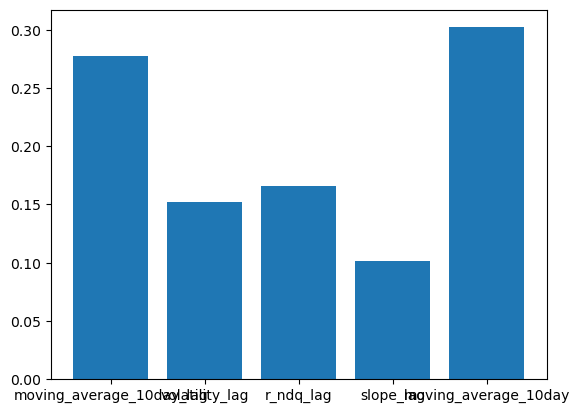

In [65]:
plt.bar(X_train_label.columns, gb_result.feature_importances_)

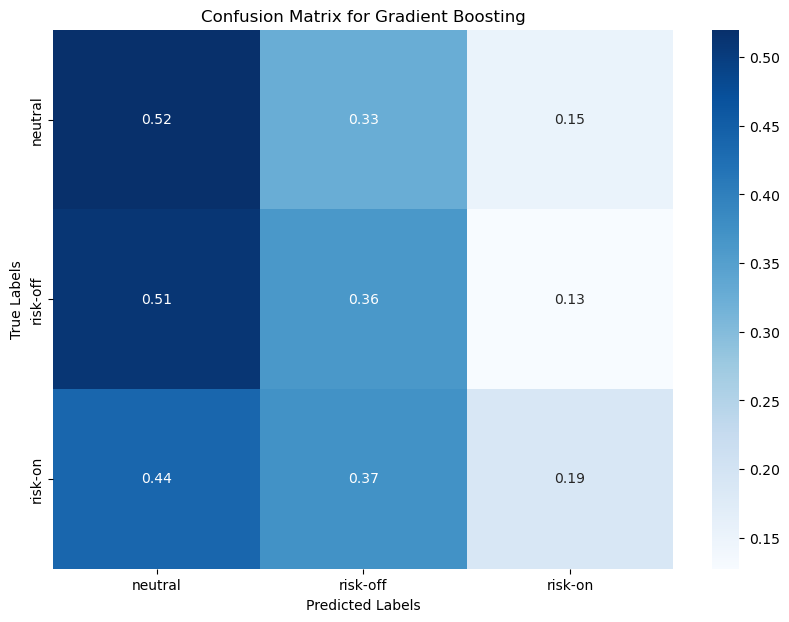

In [66]:
# Confusion Matrix
cm = confusion_matrix(y_test_label, gb_pred, normalize = 'true')
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=np.unique(y_test_label), yticklabels=np.unique(y_test_label))
plt.title(f'Confusion Matrix for {model_name}')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


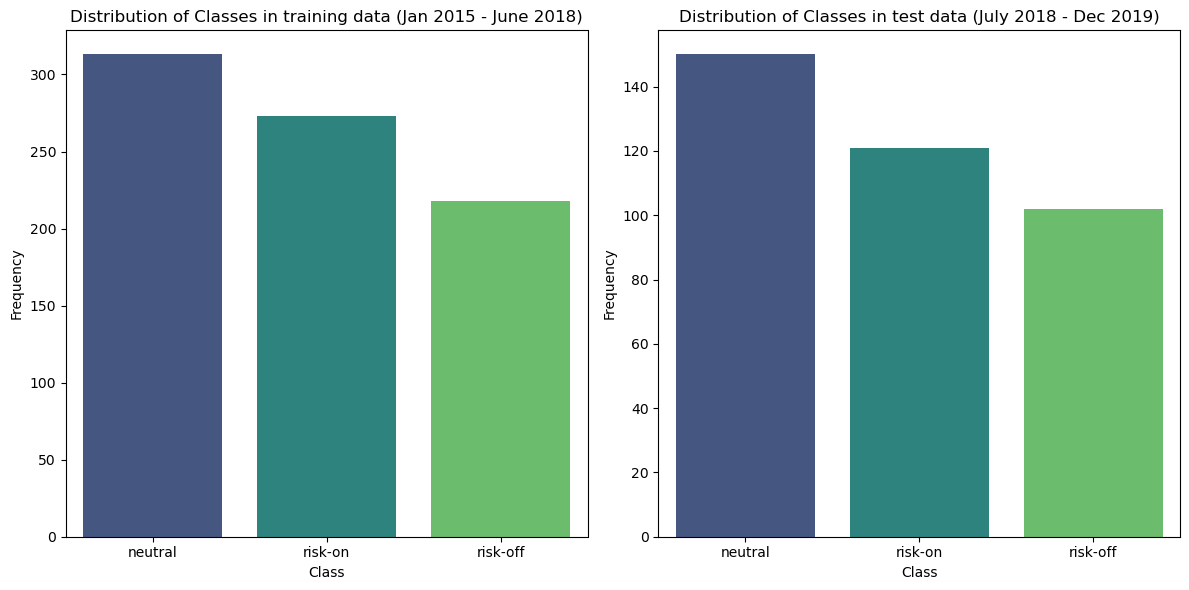

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Creating a DataFrame for easier plotting
train_df = pd.DataFrame(y_train_label, columns=['label'])
test_df = pd.DataFrame(y_test_label, columns=['label'])

# Counting the instances of each class
train_counts = train_df['label'].value_counts()
test_counts = test_df['label'].value_counts()

# Creating the bar plot
plt.figure(figsize=(12, 6))

# Plotting training data
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.barplot(x=train_counts.index, y=train_counts.values, palette='viridis')
plt.title('Distribution of Classes in training data (Jan 2015 - June 2018)')
plt.xlabel('Class')
plt.ylabel('Frequency')

# Plotting testing data
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.barplot(x=test_counts.index, y=test_counts.values, palette='viridis')
plt.title('Distribution of Classes in test data (July 2018 - Dec 2019)')
plt.xlabel('Class')
plt.ylabel('Frequency')

# Displaying the plot
plt.tight_layout()
plt.show()


#### Change it to rolling window, or maybe expanding window:

Model:   Random Forest


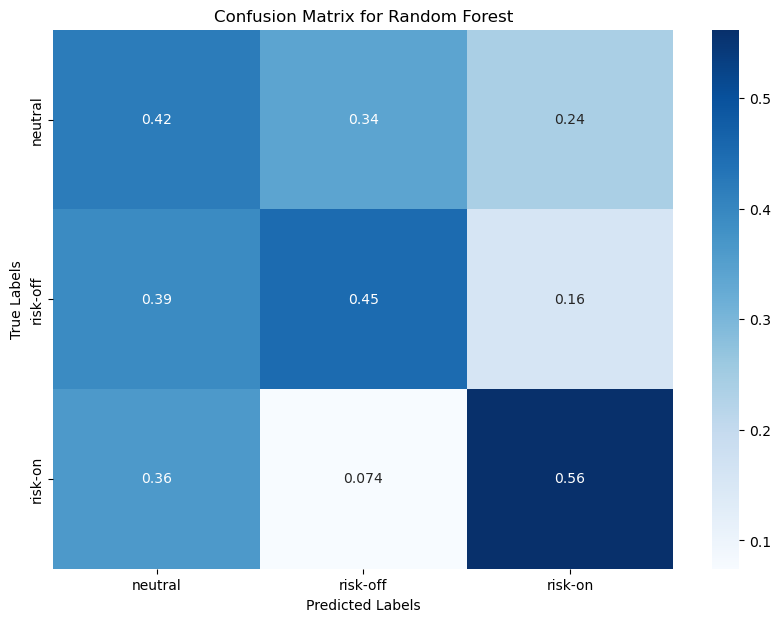

              precision    recall  f1-score   support

     neutral       0.43      0.42      0.42       150
    risk-off       0.43      0.45      0.44       102
     risk-on       0.57      0.56      0.56       121

    accuracy                           0.47       373
   macro avg       0.48      0.48      0.48       373
weighted avg       0.47      0.47      0.47       373

Model:   Gradient Boosting


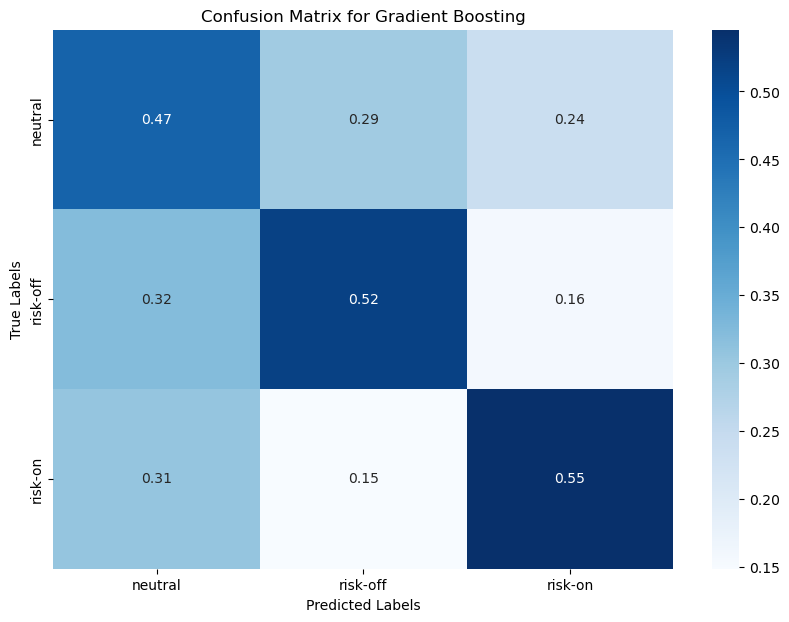

              precision    recall  f1-score   support

     neutral       0.50      0.47      0.48       150
    risk-off       0.46      0.52      0.49       102
     risk-on       0.56      0.55      0.55       121

    accuracy                           0.51       373
   macro avg       0.51      0.51      0.51       373
weighted avg       0.51      0.51      0.51       373

{'Random Forest': {'Accuracy': 0.4745308310991957, 'Precision': 0.4748432490503409, 'Recall': 0.4745308310991957, 'Best Params': {'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 25}}, 'Gradient Boosting': {'Accuracy': 0.5067024128686327, 'Precision': 0.508543329098844, 'Recall': 0.5067024128686327, 'Best Params': {'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 25}}}


In [68]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
import seaborn as sns  

# Models to be used
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Hyperparameters for tuning
parameters = {
    "Random Forest": {'max_depth': 1, 'n_estimators': 10},
    "Gradient Boosting": {'learning_rate': 0.75, 'max_depth': 10, 'n_estimators': 40}
}

# Storing model performance
model_performance = {}

# Tuning hyperparameters and evaluating each model
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]

    predictions = []
    actuals = y_test_label.copy()  # assuming y_test is your out-of-sample data
    
    for i in range(len(X_test_label)):  # assuming X_test_lags is the test set features
        # Define the start point for the training window
        start_point = max(0, len(X_train_label) + i - window_size)
        end_point = len(X_train_label) + i

        # Train model on current window data
        X_train_rolling = pd.concat([X_train_label, X_test_label.iloc[:i]]).iloc[start_point:end_point]
        y_train_rolling = pd.concat([y_train_label, y_test_label.iloc[:i]]).iloc[start_point:end_point]
        
        # Fit the model with the best parameters (simplified for demo)
        model.set_params(**params)
        model.fit(X_train_rolling, y_train_rolling)
        
        # Make a prediction for the next point
        next_point_prediction = model.predict(X_test_label.iloc[[i]])
        predictions.append(next_point_prediction[0])

    
    # Evaluate the model
    accuracy = accuracy_score(actuals, predictions)
    precision = precision_score(actuals, predictions, average='weighted')
    recall = recall_score(actuals, predictions, average='weighted')

    # Confusion Matrix
    cm = confusion_matrix(actuals, predictions, normalize = 'true')
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=np.unique(y_test_label), yticklabels=np.unique(y_test_label))
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Store results
    model_performance[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Best Params': param_search.best_params_
    }
    
    # Optionally print a detailed classification report
    print(classification_report(actuals, predictions))

# Output model performance
print(model_performance)


Calculate sharpe for the classification prediction:

In [69]:
def sharpe_classification(pred_label):
    w_ndq = []
    w_rf = []
    for label in pred_label:
        if label == 'risk-on': #23: changing to see if it improves
            w_ndq.append(0.8)
            w_rf.append(0.2)
        elif label == 'neutral': # was 20:
            w_ndq.append(0.6)
            w_rf.append(0.4)
        elif label == 'risk-off':
            w_ndq.append(0.2)
            w_rf.append(0.8)
    portfolio_df_sent_test['w_ndq'] = w_ndq
    portfolio_df_sent_test['w_rf'] = w_rf
    portfolio_df_sent_test['r_portfolio'] = portfolio_df_sent_test['w_ndq'] * portfolio_df_sent_test['r_ndq'] + portfolio_df_sent_test['w_rf'] * portfolio_df_sent_test['r_rf']
    portfolio_df_sent_test['excess returns'] = portfolio_df_sent_test['r_portfolio'] - portfolio_df_sent_test['rf_rate']
    portfolio_df_sent_test['trading day'] = (portfolio_df_sent_test['w_ndq'] != portfolio_df_sent_test['w_ndq'].shift(1)).astype(int)
    mean_return_portfolio = portfolio_df_sent_test['r_portfolio'].mean()
    std_excess = np.std(portfolio_df_sent_test['excess returns'])
    mean_risk_free_rate = portfolio_df_sent_test['rf_rate'].mean()
    sharpe_ratio = (mean_return_portfolio - mean_risk_free_rate)/std_excess
    return sharpe_ratio

In [70]:
sharpe_classification(y_test_label)

0.15136494405878678

In [71]:
sharpe_classification(predictions)

0.07386199262021692

### Try SVM:

In [72]:
# Classification with SVM
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve
svm_results = {}
conf_matrix_svm = {}
roc_svm = {}
# Values of C and gamma for tuning:
C_range = np.linspace(1, 10, 11)
gamma_range = np.linspace(0.1, 1, 10)
param_grid = dict(gamma=gamma_range, C=C_range)
C_dict = dict(C=C_range)
for kernel in ['linear', 'poly', 'rbf']:
    # For the linear kernel, we only need to tune C (gamma is just for nonlinear kernels):
    if kernel == 'linear':
        svm = GridSearchCV(SVC(kernel=kernel, probability = True), C_dict, cv=3)
    else:
        svm = RandomizedSearchCV(SVC(kernel=kernel, probability = True), param_grid, cv=3)
 
    svm.fit(X_train_label, y_train_label)
 
    print(kernel, ": The best parameters are %s"
        % (svm.best_params_)
    )
 
    y_pred_label = svm.predict(X_test_label)
    accuracy = svm.score(X_test_label, y_test_label)
    precision = precision_score(y_test_label, y_pred_label, average='weighted')
    recall = recall_score(y_test_label, y_pred_label, average='weighted')
    f1 = f1_score(y_test_label, y_pred_label, average='weighted')
 
#y_prob = svm.predict_proba(X_test_label)[:, 1]
#roc_auc = roc_auc_score(y_test_label, y_prob)
#fpr, tpr, _ = roc_curve(y_test_label, y_prob)
 
#roc_svm[kernel] = {
#    'FPR' : fpr,
#    'TPR' : tpr
#}
 
    conf_matrix_svm[kernel] = {'Confusion Matrix' : confusion_matrix(y_test_label, y_pred_label)}
    svm_results[kernel] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
#    'ROC-AUC': roc_auc
    }
# Display results
pd.DataFrame(svm_results)

linear : The best parameters are {'C': 9.1}


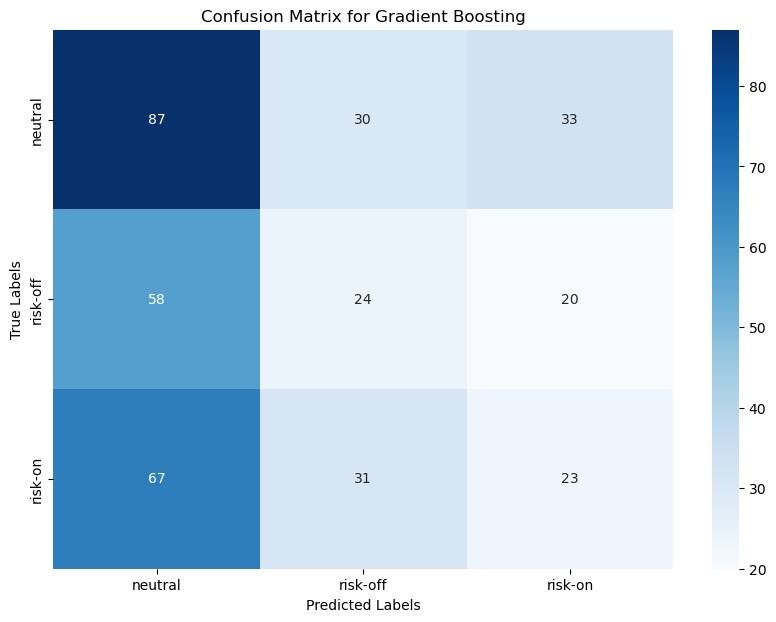

In [ ]:
cm = confusion_matrix(y_test_label, y_pred_label)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=np.unique(y_test_label), yticklabels=np.unique(y_test_label))
plt.title(f'Confusion Matrix for {model_name}')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#### Try: add predicted moving average as an input for the classification!!

- or maybe that wouldnt work since we dont have a prediction for the training data? so would have to be the actual values for the training data and then the predicted for the test period?